# Main goal

> Compare two Nifti2 images in 3D. Let it be any level of analysis (run, group, global).

## Caveat
1. It is mentioned in the NARPS paper that negative activation has importance (from what we understood). We should keep relative integers for image comparison
2. It appears that usually images are compared using only absolute values
3. So we will code both options
   
# Process

1. Resample both images to the same standard template: mni152 (images interpolation)
2. Retheshold both images to remove noise with absolute values under 0.19 set to 0
3. Build a Dice coefficient of the images (it is a good indicator that also keeps spatial information according to [https://inserm.hal.science/inserm-01760535/])

In [1]:
!pip install dicom2nifti nibabel nilearn scipy numpy matplotlib

import dicom2nifti
import nibabel as nib
from nibabel.processing import resample_from_to
import nilearn as nil
from nilearn import plotting
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os
import numpy as np
from nilearn.datasets import load_mni152_template
from nilearn.image import resample_to_img

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


# Exploring raw images

In [11]:
template = load_mni152_template(resolution=1)
img1="../narps_open_pipelines/run/reproduced/NARPS-2T6S-reproduced_r2017b_10_run1/l2_analysis_equalIndifference_nsub_10/_contrast_id_0001/_threshold0/spmT_0001_thr.nii"
img2="../narps_open_pipelines/run/reproduced/NARPS-2T6S-reproduced_r2017b_10_run2/l2_analysis_equalIndifference_nsub_10/_contrast_id_0001/_threshold0/spmT_0001_thr.nii"

#img1='NARPS - 4TQ6/hypo1_unthresh.nii.gz'
#img2='NARPS – V55J/hypo1_unthresh.nii.gz'
h1_4tq6 = nib.load(img1)
h1_v55j = nib.load(img2)
print("shape 1:",h1_4tq6.shape)
print("shape 2:",h1_v55j.shape)


shape 1: (97, 115, 81)
shape 2: (97, 115, 81)


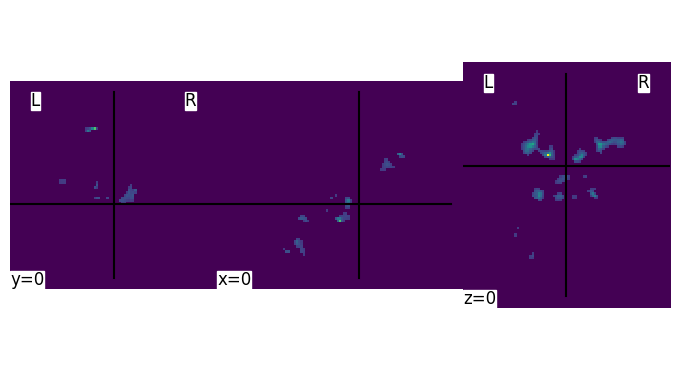

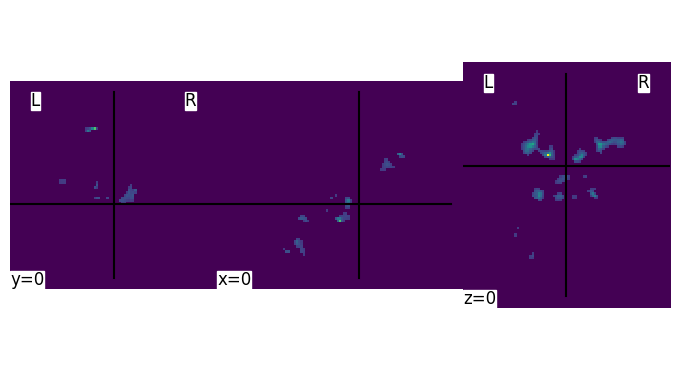

In [12]:
plotting.plot_img(h1_4tq6,cut_coords=(0,0,0))
plotting.plot_img(h1_v55j,cut_coords=(0,0,0))

# Resampling

In [4]:
h1_4tq6 = resample_to_img(h1_4tq6, template)
h1_v55j=resample_to_img(h1_v55j, template)

print("RESAMPLED:")
print("shape 1 resampled:", h1_4tq6.shape)
print("shape 1 resampled:",h1_v55j.shape)

RESAMPLED:
shape 1 resampled: (197, 233, 189)
shape 1 resampled: (197, 233, 189)


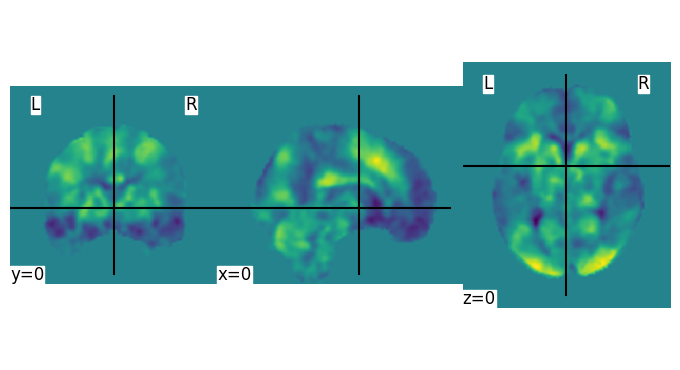

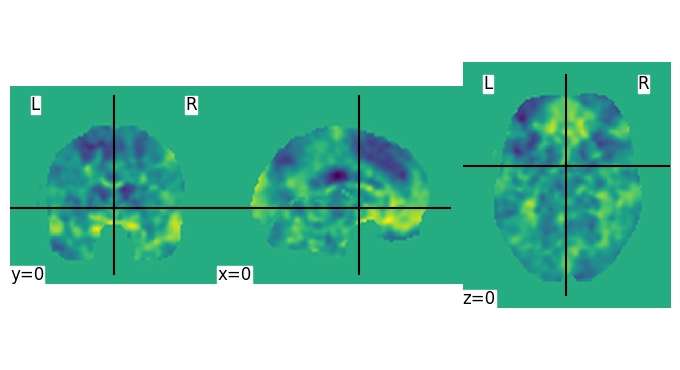

In [5]:
plotting.plot_img(h1_4tq6,cut_coords=(0,0,0))
plotting.plot_img(h1_v55j,cut_coords=(0,0,0))

# Define the Dice-coefficient utilites

## Axiomatic
> We choose to set the inteserction with discrete values in [-1,0,1]

**This choice is made to show how well activiation is represented in each image. However it is questionable. For, we loose the intensity variation.**

> Dice coeff. cardinals ignore zero values in order to focus on activated zones

> Three different Dice coeffs. can be built:
> 1. Dice coeff. of positive acvivation values
> 2. Dice coeff. of negative activation values
> 3. Dice coeff. composed of absolute activation values


In [7]:
neg_to_zero= lambda x: 0 if x < 0 else x
neg_to_zero = np.vectorize(neg_to_zero)

pos_to_zero= lambda x: 0 if x > 0 else x
pos_to_zero = np.vectorize(pos_to_zero)

pos_to_neg= lambda x: -1 if x > 0 else x
pos_to_neg = np.vectorize(pos_to_neg)


def np_intersect_slice(a,b)->np.array:
    assert(a.shape == b.shape)
    assert(len(a.shape)==2)
    return np.logical_and(a,b).astype(float)

def intersect_slice(a,b)->np.array:
    assert(a.shape == b.shape)
    assert(len(a.shape)==2)
    out = []
    for row in range(0,len(a)):
        intersection = []
        for col in range(0,len(a[row])):
            value = 0.0
            if a[row,col]>0 and b[row,col]>0:
                value =1.0
            if a[row,col]< -0 and b[row,col]< -0:
                value = -1.0
            intersection+=[value]
        out+=[intersection]

    return np.array(out)

def intersect_nifti(a,b,abs=True,keep_sign=True)-> nib.Nifti2Image:
    assert(a.shape==b.shape)
    adata = np.absolute(a.get_fdata()) if abs else a.get_fdata()
    bdata = np.absolute(b.get_fdata()) if abs else b.get_fdata()
    adata=np.nan_to_num(adata)
    bdata=np.nan_to_num(bdata)

    if abs:
        img = np.logical_and(adata,bdata).astype(float)
        img = nib.Nifti2Image(img,np.eye(4))
        return img
    else:
        if keep_sign:
            img = []
            for i in range(0,len(adata)):
                img+=[intersect_slice(adata[i],bdata[i])]
            img = np.array(img)
            img = nib.Nifti2Image(img,np.eye(4))
            return img
        
        else:
            aneg,bneg = pos_to_zero(adata),pos_to_zero(bdata)
            apos,bpos = neg_to_zero(adata),neg_to_zero(bdata)

            img_neg = np.logical_and(aneg,bneg).astype(float)
            img_neg = pos_to_neg(img_neg)
            img_pos = np.logical_and(apos,bpos).astype(float)

            img = nib.Nifti2Image(np.logical_or(img_neg,img_pos).astype(float),np.eye(4))

            return img

def cardinal(a:nib.Nifti2Image,pos=True,abs=True)->int:
    data = np.absolute(a.get_fdata()) if abs else a.get_fdata()
    data=np.nan_to_num(data)
    total_card = 0
    if pos:
        return np.count_nonzero(data)
        #for slice in data:
        #    for row in slice:
        #        total_card += sum(list(map(lambda x: 1 if x>0 else 0,row)))
    else:
        return np.count_nonzero(pos_to_zero(data))
        #for slice in data:
        #    for row in slice:
        #        total_card += sum(list(map(lambda x: 1 if x<0 else 0,row)))
    return total_card


#2 * |X ∩ Y| / (|X| + |Y|)
def dice(a,b,inter=None,pos=True,abs=True,keep_sign=True)->float:
    if inter is not None:
        return 2 * cardinal(inter,pos,abs)/(cardinal(a,pos,abs)+cardinal(b,pos,abs))
    else:  
        return 2 * cardinal(intersect_nifti(a,b,abs,keep_sign),pos,abs)/(cardinal(a,pos,abs)+cardinal(b,pos,abs))


# Build the intersection 
1. **Without Thresolding**

In [18]:
dice(h1_v55j,h1_4tq6,keep_sign=True, abs=False)

1.0

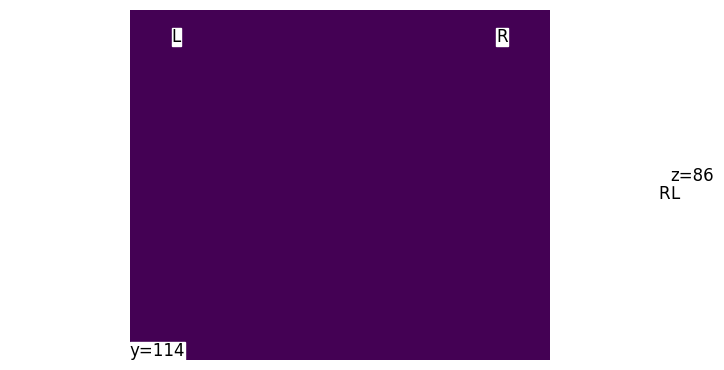

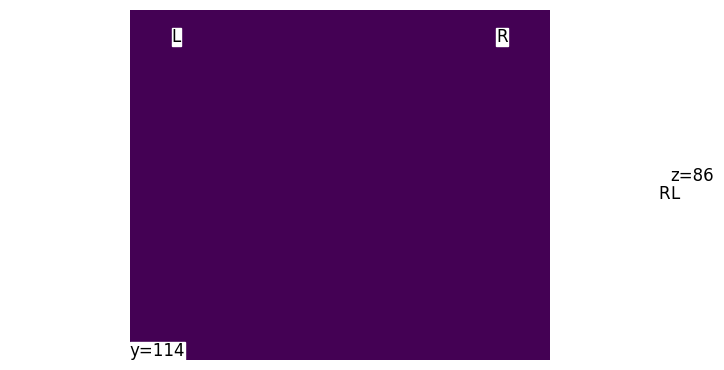

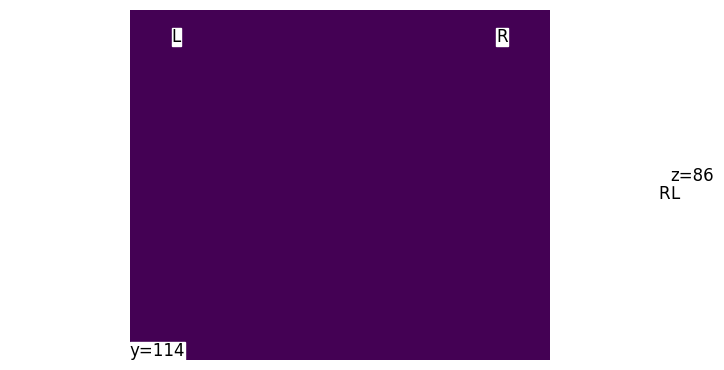

In [8]:
plotting.plot_img(intersect_nifti(h1_4tq6,h1_v55j,abs=False),cut_coords=(98,114,86))
plotting.plot_img(intersect_nifti(h1_4tq6,h1_v55j,abs=False,keep_sign=False),cut_coords=(98,114,86))
plotting.plot_img(intersect_nifti(h1_4tq6,h1_v55j,abs=True),cut_coords=(98,114,86))

> We observe that noise is present on the image due to resampling. We choose to remove that noise using an (arbitrary) absolute threshold of 0.19

2. **With Thresholding**

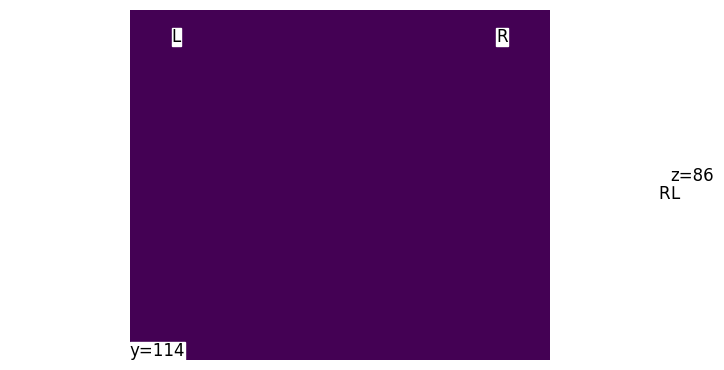

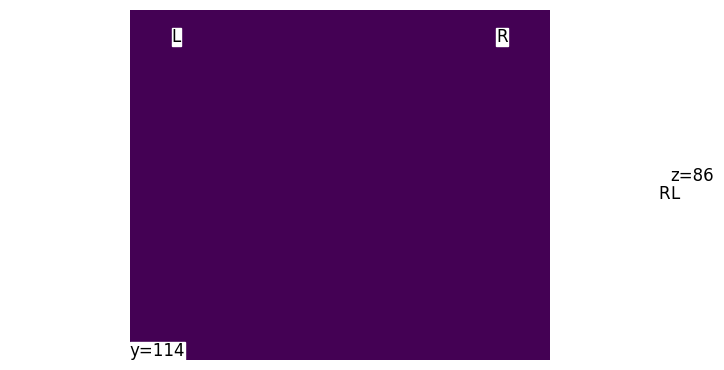

In [9]:
h1_4tq6 = nil.image.threshold_img(h1_4tq6,0.19)
h1_v55j = nil.image.threshold_img(h1_v55j,0.19)
plotting.plot_img(intersect_nifti(h1_4tq6,h1_v55j,abs=False),cut_coords=(98,114,86))
plotting.plot_img(intersect_nifti(h1_4tq6,h1_v55j,abs=True),cut_coords=(98,114,86))

# Compute Dice coefficients
## Non exhaustive testing
> **First we will attest that self-computed Dice coefficient is equal to 1.0**

In [10]:
assert(dice(h1_4tq6,h1_4tq6,pos=True,abs=False)==1.0)
assert(dice(h1_4tq6,h1_4tq6,pos=False,abs=False)==1.0)
assert(dice(h1_4tq6,h1_4tq6)==1.0)

assert(dice(h1_v55j,h1_v55j,pos=True,abs=False)==1.0)
assert(dice(h1_v55j,h1_v55j,pos=False,abs=False)==1.0)
assert(dice(h1_v55j,h1_v55j)==1.0)


ZeroDivisionError: division by zero

> **Then we assess that Dice coefficient is equal when parameters are permuted**

In [11]:
assert(dice(h1_v55j,h1_4tq6)==dice(h1_4tq6,h1_v55j))
assert(dice(h1_v55j,h1_4tq6,pos=False,abs=False)==dice(h1_4tq6,h1_v55j,pos=False,abs=False))

## Dice coefficients for our pair of data

1. **For positive values**

In [12]:
dice(h1_4tq6,h1_v55j,abs=False)

0.19887714864116673

2. **For negative values**

In [13]:
dice(h1_4tq6,h1_v55j,pos=False,abs=False)

0.24098483701447437

3. **Naive global Dice**

In [14]:
dice(h1_4tq6,h1_v55j,pos=True,abs=True)

0.8695537685304172

In [9]:
def load_team(path)->list[(str,nib.Nifti2Image)]:
    files=[]
    dir_files=os.listdir(path)
    dir_files.sort()
    for file in dir_files:
        print('loading',path+'/'+file)
        files+=[(file,nib.load(path+'/'+file))]
        files.sort()
    return files
    

In [10]:
all_folders = os.listdir('.')
all_folders
teams=[]
for filename in all_folders:
    if "NARPS" in filename:
        if os.path.isdir(filename):
            teams+=[os.getcwd()+'/'+filename]
teams

['/Users/michel/workspace/narps/NARPS-L1A8',
 '/Users/michel/workspace/narps/NARPS - P5F3',
 '/Users/michel/workspace/narps/NARPS - C88N',
 '/Users/michel/workspace/narps/NARPS - C22U',
 '/Users/michel/workspace/narps/NARPS - 4TQ6',
 '/Users/michel/workspace/narps/NARPS - 16IN',
 '/Users/michel/workspace/narps/NARPS – E6R3',
 '/Users/michel/workspace/narps/NARPS-43FJ',
 '/Users/michel/workspace/narps/NARPS - 1KB2',
 '/Users/michel/workspace/narps/NARPS – L9G5',
 '/Users/michel/workspace/narps/NARPS - 0ED6',
 '/Users/michel/workspace/narps/NARPS - R7D1',
 '/Users/michel/workspace/narps/NARPS - 1K0E',
 '/Users/michel/workspace/narps/NARPS - 9T8E',
 '/Users/michel/workspace/narps/NARPS –  E3B6',
 '/Users/michel/workspace/narps/NARPS-80GC',
 '/Users/michel/workspace/narps/NARPS – DC61',
 '/Users/michel/workspace/narps/NARPS-X1Y5',
 '/Users/michel/workspace/narps/NARPS-L3V8',
 '/Users/michel/workspace/narps/NARPS_XU70',
 '/Users/michel/workspace/narps/NARPS-5G9K',
 '/Users/michel/workspace/

# EXPERIMENTAL AREA

In [18]:
#EMPENN DICE

import nibabel as nib
from nibabel.processing import resample_from_to
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import scipy
import os
import warnings

def sorrenson_dice(data1_img, data2_img, reslice=True):
    # Load nifti images
    #data1_img = nib.load(data1_file)
    #data2_img = nib.load(data2_file)

    # Load data from images
    data2 = data2_img.get_fdata()
    data1 = data1_img.get_fdata()

    # Get asbolute values (positive and negative blobs are of interest)
    data2 = np.absolute(data2)
    data1 = np.absolute(data1)

    if reslice:
        # Resample data1 on data2 using nearest nneighbours
        data1_resl_img = resample_from_to(data1_img, data2_img, order=0)
        # Load data from images
        data1_res = data1_resl_img.get_fdata()
        data1_res = np.absolute(data1_res)
            
        # Resample data2 on data1 using nearest nneighbours
        data2_resl_img = resample_from_to(data2_img, data1_img, order=0)        
        data2_res = data2_resl_img.get_fdata()
        data2_res = np.absolute(data2_res)

    # Masking (compute Dice using intersection of both masks)
    if reslice:
        background_1 = np.logical_or(np.isnan(data1), np.isnan(data2_res))
        background_2 = np.logical_or(np.isnan(data1_res), np.isnan(data2))

        data1 = np.nan_to_num(data1)
        data1_res = np.nan_to_num(data1_res)
        data2 = np.nan_to_num(data2)
        data2_res = np.nan_to_num(data2_res)

        num_activated_1 = np.sum(data1 > 0)
        num_activated_res_1 = np.sum(data1_res>0)
        num_activated_2 = np.sum(data2>0)
        num_activated_res_2 = np.sum(data2_res>0)

        dark_dice_1 = np.zeros(2)
        if num_activated_1 != 0:
            dark_dice_1[0] = np.sum(data1[background_1]>0).astype(float)/num_activated_1*100
        if num_activated_res_1 != 0:
            dark_dice_1[1] = np.sum(data1_res[background_2]>0).astype(float)/num_activated_res_1*100

        dark_dice_2 = np.zeros(2)
        if num_activated_2 != 0:
            dark_dice_2[0] = np.sum(data2[background_2]>0).astype(float)/num_activated_2*100
        if num_activated_res_2 != 0:
            dark_dice_2[1] = np.sum(data2_res[background_1]>0).astype(float)/num_activated_res_2*100

        data1[background_1] = 0
        data2_res[background_1] = 0

        data1_res[background_2] = 0
        data2[background_2] = 0
    else:
        background = np.logical_or(np.isnan(data1), np.isnan(data2))

        data1 = np.nan_to_num(data1)
        data2 = np.nan_to_num(data2)

        num_activated_1 = np.sum(data1 > 0)
        num_activated_2 = np.sum(data2>0)

        dark_dice = np.zeros(2)
        if num_activated_1 !=0:
            dark_dice[0] = np.sum(data1[background]>0).astype(float)/num_activated_1*100

        if num_activated_2 !=0:
            dark_dice[1] = np.sum(data2[background]>0).astype(float)/num_activated_2*100

        data1[background] = 0
        data2[background] = 0

    # Vectorize
    data1 = np.reshape(data1, -1)
    data2 = np.reshape(data2, -1)
    if reslice:
        data1_res = np.reshape(data1_res, -1)
        data2_res = np.reshape(data2_res, -1)

    if reslice:
        dice_res_1 = 1-scipy.spatial.distance.dice(data1_res>0, data2>0)
        dice_res_2 = 1-scipy.spatial.distance.dice(data1>0, data2_res>0)

        if not np.isclose(dice_res_1, dice_res_2, atol=0.01):
            warnings.warn("Resliced 1/2 and 2/1 dices are not close")

        if not np.isclose(dark_dice_1[0], dark_dice_1[1], atol=0.01):
            warnings.warn("Resliced 1/2 and 2/1 dark dices 1 are not close")

        if not np.isclose(dark_dice_2[0], dark_dice_2[1], atol=0.01):
            warnings.warn("Resliced 1/2 and 2/1 dark dices 2 are not close")

        dices = (dice_res_1, dark_dice_1[1], dark_dice_2[1])
    else:
        dices = (1-scipy.spatial.distance.dice(data1>0, data2>0), dark_dice[0], dark_dice[1])
    
    return dices


In [ ]:
data = {t:load_team(t) for t in teams}
print('#####################################################')
coeffs = {}
images={}
for team in list(data.keys()):
    #print(team)
    hyps1=data.get(team)
    team_coeffs={}
    teams_images={}
    for team2 in set(list(data.keys()))-set([team]):
        #print(team2)
        hyps2=dict(data.get(team2))
        team2_coeffs={}
        for hyp in hyps1:
            try:
                file_name=hyp[0]
                img1=hyp[1]
                print(img1.get_filename())
                img1=resample_to_img(img1,template)
                img1=nil.image.threshold_img(img1,0.19)
                img2=hyps2.get(file_name)
                #print(img1.shape)
                print(img2.get_filename())
                img2=resample_to_img(img2,template)
                img2=nil.image.threshold_img(img2,0.19)
                #print(img2.shape)
                teams_images.update({team2+'-'+file_name:(img1,img2)})
                dice_coeff=dice(img1,img2,pos=True,abs=True)
                empenn_dice_coeff=sorrenson_dice(hyp[1],hyps2.get(file_name))
                print('Ours:',dice_coeff,'Empenn:',empenn_dice_coeff)
                print('#####################################################')
                team2_coeffs.update({file_name:(dice_coeff,empenn_dice_coeff)})
            except:
                print("ERROR FOR HYP",hyp,"FOR TEAMS",team,team2)
        images.update({team:teams_images})
        team_coeffs.update({team2:team2_coeffs})
    data.pop(team)
    coeffs.update({team:team_coeffs})
            
        
    

loading /home/tritbool/workspace/narps/NARPS – E6R3/hypo1_thresh.nii.gz
loading /home/tritbool/workspace/narps/NARPS – E6R3/hypo1_unthresh.nii.gz
loading /home/tritbool/workspace/narps/NARPS – E6R3/hypo2_thresh.nii.gz
loading /home/tritbool/workspace/narps/NARPS – E6R3/hypo2_unthresh.nii.gz
loading /home/tritbool/workspace/narps/NARPS – E6R3/hypo3_thresh.nii.gz
loading /home/tritbool/workspace/narps/NARPS – E6R3/hypo3_unthresh.nii.gz
loading /home/tritbool/workspace/narps/NARPS – E6R3/hypo4_thresh.nii.gz
loading /home/tritbool/workspace/narps/NARPS – E6R3/hypo4_unthresh.nii.gz
loading /home/tritbool/workspace/narps/NARPS – E6R3/hypo5_thresh.nii.gz
loading /home/tritbool/workspace/narps/NARPS – E6R3/hypo5_unthresh.nii.gz
loading /home/tritbool/workspace/narps/NARPS – E6R3/hypo6_thresh.nii.gz
loading /home/tritbool/workspace/narps/NARPS – E6R3/hypo6_unthresh.nii.gz
loading /home/tritbool/workspace/narps/NARPS – E6R3/hypo7_thresh.nii.gz
loading /home/tritbool/workspace/narps/NARPS – E6R3/

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:664: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(
/usr/local/lib/python3.10/dist-packages/nilearn/image/image.py:939: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  img_data = safe_get_data(img, ensure_finite=True, copy_data=copy)


Ours: 0.00010606168392324756 Empenn: (1.0, 99.99140557856082, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo1_unthresh.nii.gz
/home/tritbool/workspace/narps/NARPS-0I4U/hypo1_unthresh.nii.gz
Ours: 0.7654658286898729 Empenn: (0.7925904521276318, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo2_thresh.nii.gz
/home/tritbool/workspace/narps/NARPS-0I4U/hypo2_thresh.nii.gz


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:664: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(
/usr/local/lib/python3.10/dist-packages/nilearn/image/image.py:939: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  img_data = safe_get_data(img, ensure_finite=True, copy_data=copy)
/tmp/ipykernel_16499/2846270981.py:104: UserWarning: Resliced 1/2 and 2/1 dark dices 1 are not close
  warnings.warn("Resliced 1/2 and 2/1 dark dices 1 are not close")


Ours: 0.003648027029186499 Empenn: (0.9002123142250531, 99.63502393003478, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo2_unthresh.nii.gz
/home/tritbool/workspace/narps/NARPS-0I4U/hypo2_unthresh.nii.gz
Ours: 0.7533266409624643 Empenn: (0.7925879716754781, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo3_thresh.nii.gz
/home/tritbool/workspace/narps/NARPS-0I4U/hypo3_thresh.nii.gz


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:664: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(
/usr/local/lib/python3.10/dist-packages/nilearn/image/image.py:939: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  img_data = safe_get_data(img, ensure_finite=True, copy_data=copy)


Ours: 0.00010606168392324756 Empenn: (1.0, 99.99140557856082, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo3_unthresh.nii.gz
/home/tritbool/workspace/narps/NARPS-0I4U/hypo3_unthresh.nii.gz
Ours: 0.7654658286898729 Empenn: (0.7925904521276318, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo4_thresh.nii.gz
/home/tritbool/workspace/narps/NARPS-0I4U/hypo4_thresh.nii.gz


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:664: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(
/usr/local/lib/python3.10/dist-packages/nilearn/image/image.py:939: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  img_data = safe_get_data(img, ensure_finite=True, copy_data=copy)
/tmp/ipykernel_16499/2846270981.py:104: UserWarning: Resliced 1/2 and 2/1 dark dices 1 are not close
  warnings.warn("Resliced 1/2 and 2/1 dark dices 1 are not close")


Ours: 0.003648027029186499 Empenn: (0.9002123142250531, 99.63502393003478, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo4_unthresh.nii.gz
/home/tritbool/workspace/narps/NARPS-0I4U/hypo4_unthresh.nii.gz
Ours: 0.7533266409624643 Empenn: (0.7925879716754781, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo5_thresh.nii.gz
/home/tritbool/workspace/narps/NARPS-0I4U/hypo5_thresh.nii.gz


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:664: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(
/usr/local/lib/python3.10/dist-packages/nilearn/image/image.py:939: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  img_data = safe_get_data(img, ensure_finite=True, copy_data=copy)
/tmp/ipykernel_16499/2846270981.py:104: UserWarning: Resliced 1/2 and 2/1 dark dices 1 are not close
  warnings.warn("Resliced 1/2 and 2/1 dark dices 1 are not close")


Ours: 0.0008904923989201823 Empenn: (1.0, 99.92425053942797, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo5_unthresh.nii.gz
/home/tritbool/workspace/narps/NARPS-0I4U/hypo5_unthresh.nii.gz
Ours: 0.7617478148829938 Empenn: (0.7925904521276318, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo6_thresh.nii.gz
/home/tritbool/workspace/narps/NARPS-0I4U/hypo6_thresh.nii.gz


/tmp/ipykernel_16499/3038843559.py:25: UserWarning: The given float value must not exceed 0. But, you have given threshold=0.19.
  img2=nil.image.threshold_img(img2,0.19)


Ours: 0.0 Empenn: (0.0, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo6_unthresh.nii.gz
/home/tritbool/workspace/narps/NARPS-0I4U/hypo6_unthresh.nii.gz
Ours: 0.7190214147041899 Empenn: (0.7925879716754781, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo7_thresh.nii.gz
/home/tritbool/workspace/narps/NARPS-0I4U/hypo7_thresh.nii.gz


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:664: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(
/usr/local/lib/python3.10/dist-packages/nilearn/image/image.py:939: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  img_data = safe_get_data(img, ensure_finite=True, copy_data=copy)
/tmp/ipykernel_16499/2846270981.py:101: UserWarning: Resliced 1/2 and 2/1 dices are not close
  warnings.warn("Resliced 1/2 and 2/1 dices are not close")


Ours: 0.0029007376744138624 Empenn: (0.9879154078549849, 99.74979723629241, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo7_unthresh.nii.gz
/home/tritbool/workspace/narps/NARPS-0I4U/hypo7_unthresh.nii.gz
Ours: 0.7617478148829938 Empenn: (0.7925904521276318, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo8_thresh.nii.gz
/home/tritbool/workspace/narps/NARPS-0I4U/hypo8_thresh.nii.gz


/tmp/ipykernel_16499/3038843559.py:25: UserWarning: The given float value must not exceed 0. But, you have given threshold=0.19.
  img2=nil.image.threshold_img(img2,0.19)


Ours: 0.0 Empenn: (0.0, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo8_unthresh.nii.gz
/home/tritbool/workspace/narps/NARPS-0I4U/hypo8_unthresh.nii.gz
Ours: 0.7190214147041899 Empenn: (0.7925879716754781, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo9_thresh.nii.gz
/home/tritbool/workspace/narps/NARPS-0I4U/hypo9_thresh.nii.gz


/tmp/ipykernel_16499/3038843559.py:25: UserWarning: The given float value must not exceed 0. But, you have given threshold=0.19.
  img2=nil.image.threshold_img(img2,0.19)


Ours: 0.0 Empenn: (0.0, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo9_unthresh.nii.gz
/home/tritbool/workspace/narps/NARPS-0I4U/hypo9_unthresh.nii.gz
Ours: 0.7362721644370323 Empenn: (0.7925985273836126, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo1_thresh.nii.gz
ERROR FOR HYP ('hypo1_thresh.nii.gz', <nibabel.nifti1.Nifti1Image object at 0x75905a127f40>) FOR TEAMS /home/tritbool/workspace/narps/NARPS – E6R3 /home/tritbool/workspace/narps/NARPS-L7J7
/home/tritbool/workspace/narps/NARPS – E6R3/hypo1_unthresh.nii.gz
ERROR FOR HYP ('hypo1_unthresh.nii.gz', <nibabel.nifti1.Nifti1Image object at 0x75905a125b40>) FOR TEAMS /home/tritbool/workspace/narps/NARPS – E6R3 /home/tritbool/workspace/narps/NARPS-L7J7
/home/tritbool/workspace/narps/NARPS – E6R3/hypo2_thresh.nii.gz
ERROR FOR HYP ('hypo2_thresh.nii.gz', <nibabel.nifti1.Nifti1Image object at 0x75905a127e50

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:293: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(


Ours: 0.02097602902771624 Empenn: (0.017904293413390282, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo1_unthresh.nii.gz
/home/tritbool/workspace/narps/NARPS-L1A8/hypo1_unthresh.nii.gz
Ours: 0.4998641924513504 Empenn: (0.5704971525130567, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo2_thresh.nii.gz
/home/tritbool/workspace/narps/NARPS-L1A8/hypo2_thresh.nii.gz


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:293: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(


Ours: 0.06809251333077868 Empenn: (0.07207408233850277, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo2_unthresh.nii.gz
/home/tritbool/workspace/narps/NARPS-L1A8/hypo2_unthresh.nii.gz
Ours: 0.5195918970870915 Empenn: (0.5739275684208593, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo3_thresh.nii.gz
/home/tritbool/workspace/narps/NARPS-L1A8/hypo3_thresh.nii.gz


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:293: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(


Ours: 0.02097602902771624 Empenn: (0.017904293413390282, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo3_unthresh.nii.gz
/home/tritbool/workspace/narps/NARPS-L1A8/hypo3_unthresh.nii.gz
Ours: 0.4998641924513504 Empenn: (0.5704971525130567, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo4_thresh.nii.gz
/home/tritbool/workspace/narps/NARPS-L1A8/hypo4_thresh.nii.gz


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:293: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(


Ours: 0.06809251333077868 Empenn: (0.07207408233850277, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo4_unthresh.nii.gz
/home/tritbool/workspace/narps/NARPS-L1A8/hypo4_unthresh.nii.gz
Ours: 0.5195918970870915 Empenn: (0.5739275684208593, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo5_thresh.nii.gz
/home/tritbool/workspace/narps/NARPS-L1A8/hypo5_thresh.nii.gz


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:293: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(


Ours: 0.060224613313751285 Empenn: (0.06123296201480666, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo5_unthresh.nii.gz
/home/tritbool/workspace/narps/NARPS-L1A8/hypo5_unthresh.nii.gz
Ours: 0.4870131612651403 Empenn: (0.5704971525130567, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo6_thresh.nii.gz
/home/tritbool/workspace/narps/NARPS-L1A8/hypo6_thresh.nii.gz


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:293: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(


Ours: 0.004417719965639956 Empenn: (0.00232666356444855, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo6_unthresh.nii.gz
/home/tritbool/workspace/narps/NARPS-L1A8/hypo6_unthresh.nii.gz
Ours: 0.5054373072177347 Empenn: (0.5739275684208593, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo7_thresh.nii.gz
/home/tritbool/workspace/narps/NARPS-L1A8/hypo7_thresh.nii.gz


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:293: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(


Ours: 0.022059358907727807 Empenn: (0.019092141888516156, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo7_unthresh.nii.gz
/home/tritbool/workspace/narps/NARPS-L1A8/hypo7_unthresh.nii.gz
Ours: 0.4870131612651403 Empenn: (0.5704971525130567, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo8_thresh.nii.gz
/home/tritbool/workspace/narps/NARPS-L1A8/hypo8_thresh.nii.gz


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:293: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(


Ours: 0.0004503305835874972 Empenn: (0.0, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo8_unthresh.nii.gz
/home/tritbool/workspace/narps/NARPS-L1A8/hypo8_unthresh.nii.gz
Ours: 0.5054373072177347 Empenn: (0.5739275684208593, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo9_thresh.nii.gz
/home/tritbool/workspace/narps/NARPS-L1A8/hypo9_thresh.nii.gz


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:293: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(


Ours: 0.054531444781452144 Empenn: (0.052308537925980225, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo9_unthresh.nii.gz
/home/tritbool/workspace/narps/NARPS-L1A8/hypo9_unthresh.nii.gz
Ours: 0.4695009303964772 Empenn: (0.5286653764432139, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo1_thresh.nii.gz
ERROR FOR HYP ('hypo1_thresh.nii.gz', <nibabel.nifti1.Nifti1Image object at 0x75905a127f40>) FOR TEAMS /home/tritbool/workspace/narps/NARPS – E6R3 /home/tritbool/workspace/narps/NARPS - 6VV2
/home/tritbool/workspace/narps/NARPS – E6R3/hypo1_unthresh.nii.gz
/home/tritbool/workspace/narps/NARPS - 6VV2/hypo1_unthresh.nii.gz
Ours: 0.7091824129372889 Empenn: (0.36346558543009844, 0.0, 0.0)
#####################################################
/home/tritbool/workspace/narps/NARPS – E6R3/hypo2_thresh.nii.gz
ERROR FOR HYP ('hypo2_thresh.nii.gz', <nibabel.nifti1.Nifti1

In [ ]:
coeffs

In [ ]:
team=images.get('/home/tritbool/workspace/narps/NARPS - 4TQ6')
pairs=[]
for imgs in list(team.keys()):
    pairs+=[team.get(imgs)]

In [ ]:
intersect_test = dice(intersect_nifti(h1_4tq6,h1_v55j,abs=True),intersect_nifti(pairs[1][0],pairs[1][1],abs=True),abs=True)
assert(intersect_test==1.0)
#plotting.plot_img(intersect_nifti(pairs[1][0],pairs[1][1],abs=True),cut_coords=(98,114,86))

# Thresholded images interesections

In [ ]:
plotting.plot_img(intersect_nifti(pairs[0][0],pairs[0][1],abs=True),cut_coords=(98,114,86))
plotting.plot_img(intersect_nifti(pairs[2][0],pairs[2][1],abs=True),cut_coords=(98,114,86))
plotting.plot_img(intersect_nifti(pairs[4][0],pairs[4][1],abs=True),cut_coords=(98,114,86))
plotting.plot_img(intersect_nifti(pairs[6][0],pairs[6][1],abs=True),cut_coords=(98,114,86))
plotting.plot_img(intersect_nifti(pairs[8][0],pairs[8][1],abs=True),cut_coords=(98,114,86))
plotting.plot_img(intersect_nifti(pairs[10][0],pairs[10][1],abs=True),cut_coords=(98,114,86))
plotting.plot_img(intersect_nifti(pairs[12][0],pairs[12][1],abs=True),cut_coords=(98,114,86))
plotting.plot_img(intersect_nifti(pairs[14][0],pairs[14][1],abs=True),cut_coords=(98,114,86))
plotting.plot_img(intersect_nifti(pairs[16][0],pairs[16][1],abs=True),cut_coords=(98,114,86))

# Unthresholded images interesections

In [ ]:
plotting.plot_img(intersect_nifti(pairs[1][0],pairs[1][1],abs=True),cut_coords=(98,114,86))
plotting.plot_img(intersect_nifti(pairs[3][0],pairs[3][1],abs=True),cut_coords=(98,114,86))
plotting.plot_img(intersect_nifti(pairs[5][0],pairs[5][1],abs=True),cut_coords=(98,114,86))
plotting.plot_img(intersect_nifti(pairs[7][0],pairs[7][1],abs=True),cut_coords=(98,114,86))
plotting.plot_img(intersect_nifti(pairs[9][0],pairs[9][1],abs=True),cut_coords=(98,114,86))
plotting.plot_img(intersect_nifti(pairs[11][0],pairs[11][1],abs=True),cut_coords=(98,114,86))
plotting.plot_img(intersect_nifti(pairs[13][0],pairs[13][1],abs=True),cut_coords=(98,114,86))
plotting.plot_img(intersect_nifti(pairs[15][0],pairs[15][1],abs=True),cut_coords=(98,114,86))
plotting.plot_img(intersect_nifti(pairs[17][0],pairs[17][1],abs=True),cut_coords=(98,114,86))